In [6]:
!pip install pandas numpy matplotlib seaborn wordcloud nltk

---

### **Geração e Análise de um Dataset Multimodal para Busca Semântica no Documento "Biologia Celular"**


#### **Metodologia de Construção do Dataset**

O processo de construção do dataset foi dividido em quatro etapas principais, projetadas para transformar o conteúdo bruto do PDF da UFSC encontrado por busca na internet em uma base de dados estruturada, anotada e pronta para vetorização.

**1. Extração Automatizada de Conteúdo**

A primeira etapa consistiu na extração sistemática de todos os componentes do documento PDF. Utilizando a biblioteca Python `PyMuPDF`, cada página do documento foi processada para isolar e extrair dois tipos de conteúdo:
* **Blocos de Texto:** Parágrafos, títulos e legendas foram extraídos como unidades textuais individuais.
* **Imagens:** Todos os elementos visuais, incluindo diagramas, fotografias e ilustrações relevantes, foram extraídos e salvos como arquivos de imagem individuais (PNG), com seus caminhos devidamente registrados.

Um sistema de filtragem foi implementado para descartar automaticamente conteúdo irrelevante, como imagens em branco, elementos gráficos muito pequenos e textos de metadados (créditos, sumário), garantindo a relevância do material a ser processado.

**2. Anotação via LLM (Gemini)**

Após a extração, cada item de conteúdo foi submetido a um processo de anotação utilizando um LLM ( Gemini ). O modelo tem duas funções principais:
* **Para Blocos de Texto:** Gerar um resumo conciso e uma lista de palavras-chave relevantes.
* **Para Imagens:** Analisar o conteúdo visual e gerar uma descrição textual detalhada do que a imagem representa, além de uma lista de palavras-chave associadas.

Este passo foi crucial para "traduzir" o conteúdo visual para um formato textual e para criar descrições semânticas uniformes para todos os itens do dataset, formando a base para a busca futura.

**3. Curadoria Manual e Preparação Final dos Dados**

O resultado da anotação automatizada foi salvo em um arquivo CSV, que passou por uma etapa de curadoria manual. Nesta fase, as descrições e palavras-chave foram revisadas para garantir a máxima qualidade e precisão. Após a revisão, um script de limpeza final foi executado para:
* Remover quaisquer entradas que permaneceram com dados ausentes.
* Criar uma coluna unificada, `text_for_embedding`, que combina a descrição e as palavras-chave de cada item. Este campo foi otimizado para fornecer o máximo de contexto semântico ao modelo de vetorização.

#### **Conclusão**

O processo descrito resultou na criação de um dataset multimodal robusto e de alta qualidade. Cada item, seja texto ou imagem, foi extraído, filtrado, anotado por IA, revisado manualmente e preparado para as etapa seguintes de vetorização.

In [ ]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Configurações de visualização
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

# Carregar o dataset limpo
df = pd.read_csv('data/annotations_clean.csv')

# Exibir as primeiras linhas para garantir que tudo foi carregado corretamente
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  1018 non-null   object 
 1   page                1018 non-null   float64
 2   type                1018 non-null   object 
 3   content_path        78 non-null     object 
 4   original_text       940 non-null    object 
 5   description_llm     1018 non-null   object 
 6   keywords_llm        1018 non-null   object 
 7   text_for_embedding  1018 non-null   object 
dtypes: float64(1), object(7)
memory usage: 63.8+ KB
None
          id  page  type content_path  \
0   p4_txt_2   4.0  text          NaN   
1  p4_txt_10   4.0  text          NaN   
2   p9_txt_0   9.0  text          NaN   
3   p9_txt_1   9.0  text          NaN   
4   p9_txt_2   9.0  text          NaN   

                                       original_text  \
0  B752b  Bouzon, Zenilda Laurita Biologia 

In [8]:
# 1. Número total de páginas do documento original
total_paginas = df['page'].max()
print(f"Número total de páginas no documento original: {total_paginas:.0f}\n")

# 2. Estatísticas de itens por página
itens_por_pagina_stats = df['page'].value_counts().describe()
print("Estatísticas de itens por página:")
print(itens_por_pagina_stats)

Número total de páginas no documento original: 238

Estatísticas de itens por página:
count    212.000000
mean       4.801887
std        2.309756
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       13.000000
Name: count, dtype: float64


In [9]:
# --- Análise de Comprimento das Anotações (LLM) ---

# Adiciona colunas de comprimento para análise
df['desc_len'] = df['description_llm'].str.len()
df['kw_count'] = df['keywords_llm'].str.split(',').str.len()

# 3. Comprimento médio das descrições (`description_llm`)
print(f"\nEstatísticas de comprimento das descrições (description_llm):\n{df['desc_len'].describe()}")

# 4. Comprimento médio por tipo de conteúdo
print("\nComprimento médio das descrições por tipo de conteúdo:")
print(df.groupby('type')['desc_len'].mean())

# 5. Contagem de palavras-chave (`keywords_llm`)
print(f"\nEstatísticas de contagem de palavras-chave (keywords_llm):\n{df['kw_count'].describe()}")


Estatísticas de comprimento das descrições (description_llm):
count    1018.000000
mean      386.557957
std       195.861170
min       103.000000
25%       301.000000
50%       339.000000
75%       382.000000
max      1648.000000
Name: desc_len, dtype: float64

Comprimento médio das descrições por tipo de conteúdo:
type
image    1017.012821
text      334.243617
Name: desc_len, dtype: float64

Estatísticas de contagem de palavras-chave (keywords_llm):
count    1018.000000
mean        9.556974
std         0.792787
min         6.000000
25%         9.000000
50%        10.000000
75%        10.000000
max        13.000000
Name: kw_count, dtype: float64


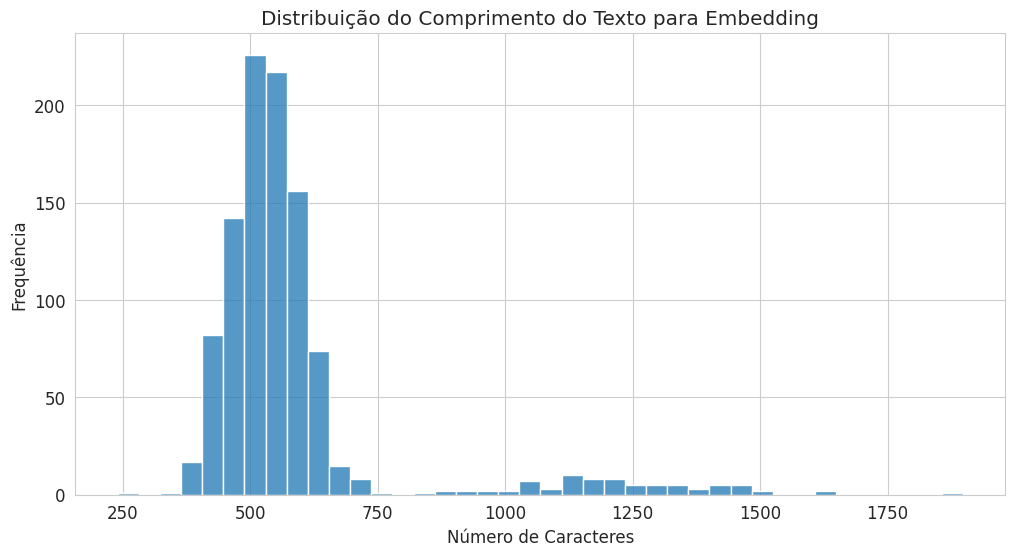


Estatísticas de comprimento do texto final para embedding (text_for_embedding):
count    1018.000000
mean      584.975442
std       202.229166
min       240.000000
25%       492.000000
50%       538.000000
75%       589.000000
max      1898.000000
Name: embed_len, dtype: float64


In [16]:
# --- Análise do Texto para Embedding ---

# Adiciona a coluna de comprimento para o texto de embedding
df['embed_len'] = df['text_for_embedding'].str.len()

# 6. Histograma do comprimento do texto para embedding
plt.figure(figsize=(12, 6))
sns.histplot(df['embed_len'], bins=40)
plt.title('Distribuição do Comprimento do Texto para Embedding')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')
plt.show()

# 7. Estatísticas detalhadas do texto para embedding
print("\nEstatísticas de comprimento do texto final para embedding (text_for_embedding):")
print(df['embed_len'].describe())

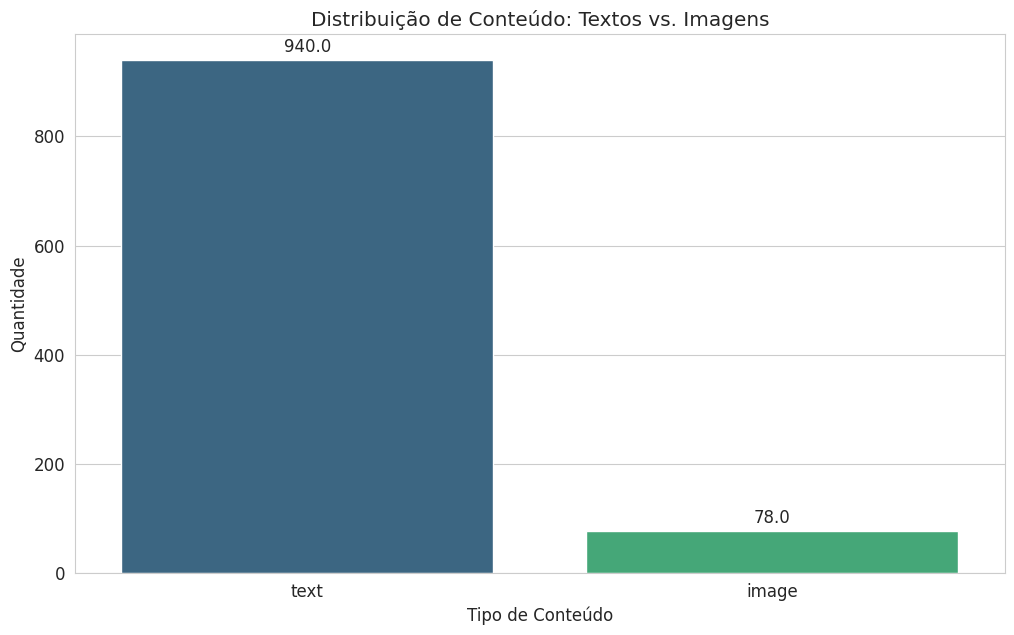

In [11]:
plt.figure()
ax = sns.countplot(x='type', data=df, palette='viridis', hue='type', legend=False)
plt.title('Distribuição de Conteúdo: Textos vs. Imagens')
plt.xlabel('Tipo de Conteúdo')
plt.ylabel('Quantidade')

# Adiciona os valores no topo das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()

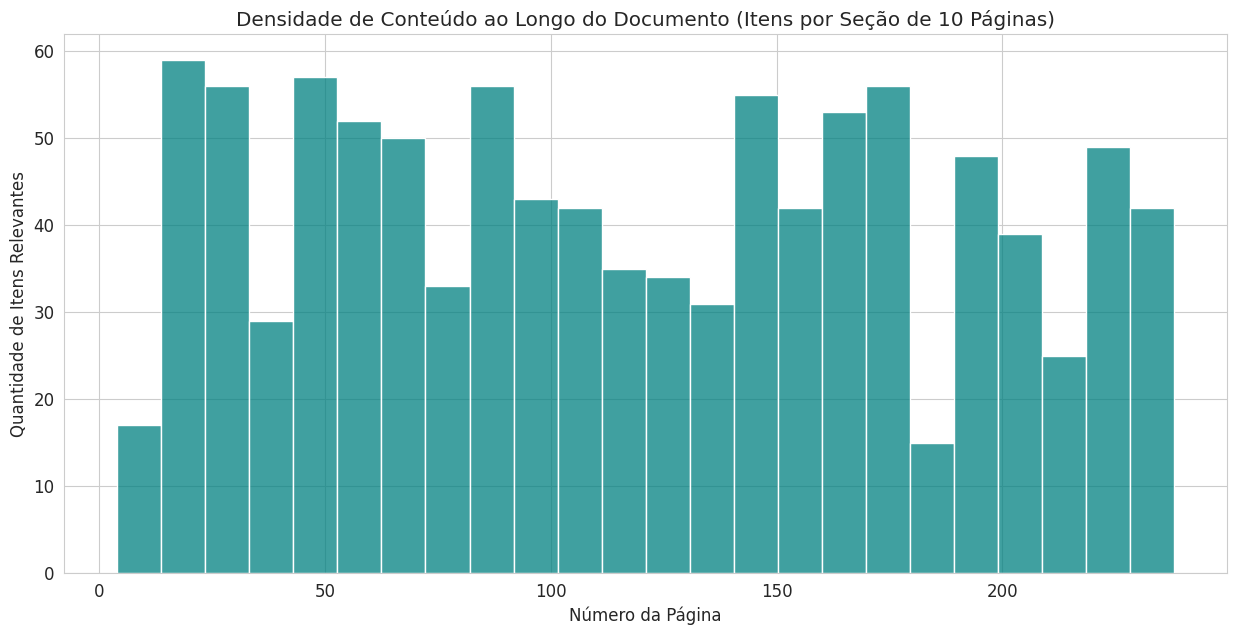

In [17]:
plt.figure(figsize=(15, 7))
sns.histplot(data=df, x='page', bins=24, color='teal') # 'bins=24' cria ~24 seções de 10 páginas
plt.title('Densidade de Conteúdo ao Longo do Documento (Itens por Seção de 10 Páginas)')
plt.xlabel('Número da Página')
plt.ylabel('Quantidade de Itens Relevantes')
plt.show()

/tmp/ipython-input-13-1601619900.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_15_pages.index, x=top_15_pages.values, orient='h', palette='magma')


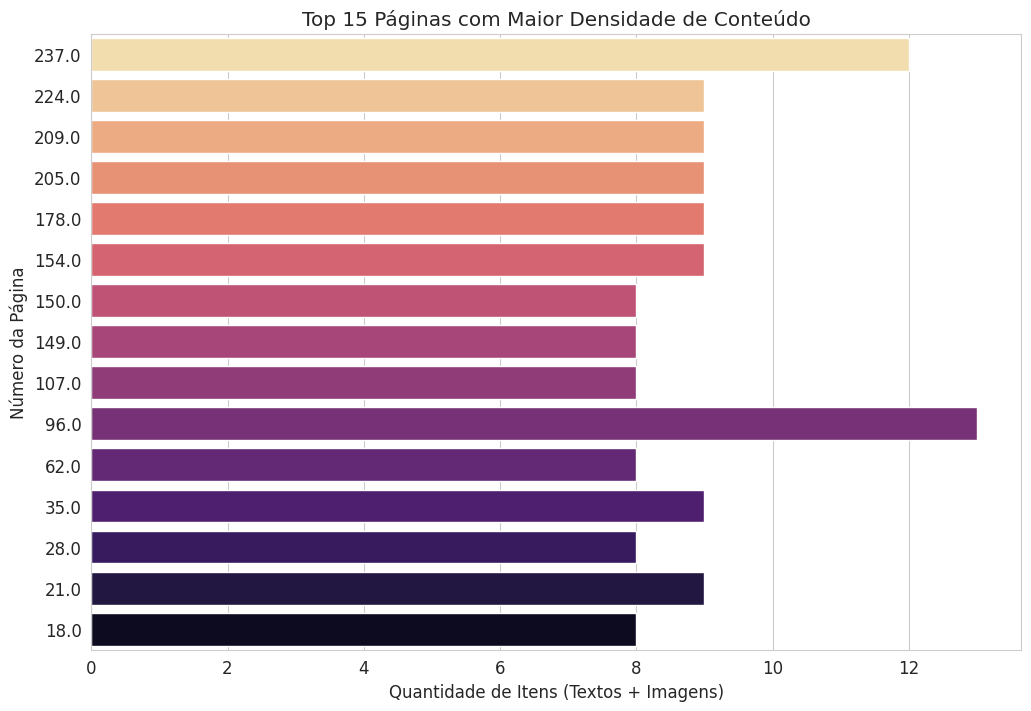

In [13]:
# Contar os itens por página e pegar as 15 páginas com mais itens
top_15_pages = df['page'].value_counts().nlargest(15)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_15_pages.index, x=top_15_pages.values, orient='h', palette='magma')
plt.title('Top 15 Páginas com Maior Densidade de Conteúdo')
plt.xlabel('Quantidade de Itens (Textos + Imagens)')
plt.ylabel('Número da Página')
# Inverte o eixo y para que a página com mais itens fique no topo
plt.gca().invert_yaxis()
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


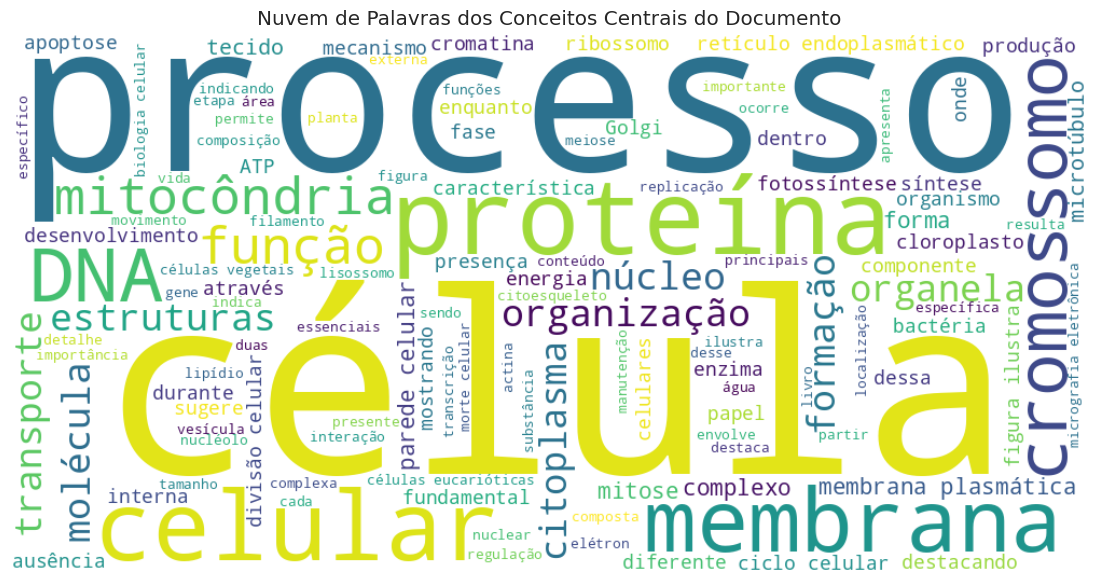

In [26]:
# Preparação do texto: juntar todas as descrições e remover stopwords
nltk.download('stopwords')
portuguese_stopwords = set(stopwords.words('portuguese'))
portuguese_stopwords.update(['imagem', 'texto', 'estrutura', 'representa', 'mostra', 'descreve', 'embora', 'crucial', 'diferença', 'provavelmente', 'processamento', 'apenas', 'demonstra', 'possivelmente', 'incluindo']) # Adicionar palavras comuns do contexto

# Concatena todas as descrições em um único texto
full_text = ' '.join(df['description_llm'].dropna())

# Cria a nuvem de palavras
wordcloud = WordCloud(width=1000, height=500, background_color='white',
                      stopwords=portuguese_stopwords, min_font_size=10).generate(full_text)

# Plota a nuvem
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Nuvem de Palavras dos Conceitos Centrais do Documento')
plt.show()

/tmp/ipython-input-15-543307011.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigram_df, palette='mako')


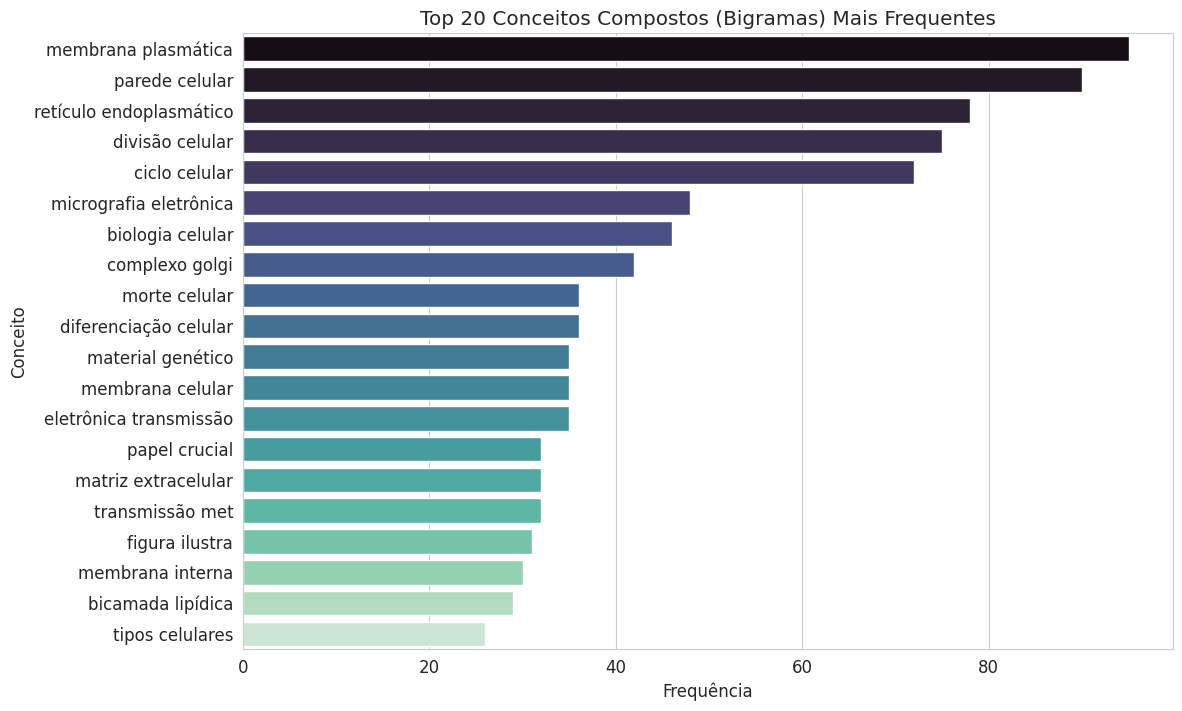

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Função para extrair N-gramas (termos com 2 ou 3 palavras)
def get_top_ngrams(corpus, ngram_range=(2, 2), top_k=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=list(portuguese_stopwords)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top_k]

# Gera e plota os 20 bigramas (2 palavras) mais comuns
top_bigrams = get_top_ngrams(df['description_llm'].dropna(), ngram_range=(2, 2), top_k=20)
bigram_df = pd.DataFrame(top_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='bigram', data=bigram_df, palette='mako')
plt.title('Top 20 Conceitos Compostos (Bigramas) Mais Frequentes')
plt.xlabel('Frequência')
plt.ylabel('Conceito')
plt.show()